In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation, Dropout, Concatenate
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
DIR = ("C:/Users/aditi/Downloads/Post-hurricane")
train_path = os.path.join(DIR, 'train_another')
val_path = os.path.join(DIR, 'validation_another')
test_path = os.path.join(DIR, 'test')

In [3]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [4]:
'''
Loading with Image Augmentation
Below I leverage the keras ImageDataGenerator to add an image augmentation pipeline. AS the training dataset is rather small (10,000 images), this will create more variation in the training dataset to reduce model overfitting and improve performance.

I limited image augmentation to a few types that are similar to the kinds of variation that might be caused by differences between instances of structures, as well as differences due to the how imagery aircraft fly.

Note that we do not do any image augmentation for the validation data.
'''
image_size = (128, 128)
batch_size = 100

# TRAINING
# specify training image transformations 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

# keras generator for training data
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')


# VALIDATION
# specify validation image transformations (rescale only)
val_datagen = ImageDataGenerator(rescale=1./255)

# keras generator for validation data
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
def plot_nn_training(history):
    
    '''Given model training history, plots validation accuracy and loss'''
    
    # plot history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # plot history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [6]:
def generate_TL_model(input_shape, num_classes):
    
    weights = 'imagenet'
    inputs = Input(input_shape)

    #what does include_top=False remove?
    base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

    #freezing the resnet layers
    for layer in base_model.layers:
        layer.trainable = False

    #these convolution layers come before the resnet layers
    x = Conv2D(32, (5, 5), strides=2, padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Flatten()(x)

    base_resnet = base_model(inputs)
    base_resnet = Flatten()(base_resnet)

    concated_layers = Concatenate()([x, base_resnet])

    # dense layers come after the resnet layers
    # dropout to reduce overfit
    concated_layers = Dense(1024, activation='relu')(concated_layers)
    concated_layers = Dropout(0.3)(concated_layers)
    concated_layers = Dense(512, activation='relu')(concated_layers)
    concated_layers = Dropout(0.2)(concated_layers)
    concated_layers = Dense(256, activation='relu')(concated_layers)
    concated_layers = Dropout(0.1)(concated_layers)
    
    # output layer
    output = Dense(num_classes, activation='softmax')(concated_layers)

    mod = Model(inputs=inputs, outputs=output)
    
    return mod

epochs = 100

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model5/best_model.keras', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Instantiate model
TL_model = generate_TL_model(input_shape=(128,128,3), num_classes=2)

# Compile model
TL_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# train model
results_TL = TL_model.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    verbose=4,
    validation_steps=20) # num_samples//batch_size

C:\Users\aditi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\aditi\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.77950, saving model to models/Model5/best_model.keras
Epoch 2/50


C:\Users\aditi\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Epoch 3/50


C:\Users\aditi\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
C:\Users\aditi\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)



Epoch 3: val_accuracy improved from 0.77950 to 0.80150, saving model to models/Model5/best_model.keras
Epoch 4/50
Epoch 5/50

Epoch 5: val_accuracy improved from 0.80150 to 0.81500, saving model to models/Model5/best_model.keras
Epoch 6/50
Epoch 7/50

Epoch 7: val_accuracy improved from 0.81500 to 0.85350, saving model to models/Model5/best_model.keras
Epoch 8/50
Epoch 9/50

Epoch 9: val_accuracy improved from 0.85350 to 0.87100, saving model to models/Model5/best_model.keras
Epoch 10/50
Epoch 11/50

Epoch 11: val_accuracy did not improve from 0.87100
Epoch 12/50
Epoch 13/50

Epoch 13: val_accuracy improved from 0.87100 to 0.89050, saving model to models/Model5/best_model.keras
Epoch 14/50
Epoch 15/50

Epoch 15: val_accuracy improved from 0.89050 to 0.89850, saving model to models/Model5/best_model.keras
Epoch 16/50
Epoch 17/50

Epoch 17: val_accuracy improved from 0.89850 to 0.90350, saving model to models/Model5/best_model.keras
Epoch 18/50
Epoch 19/50

Epoch 19: val_accuracy did no

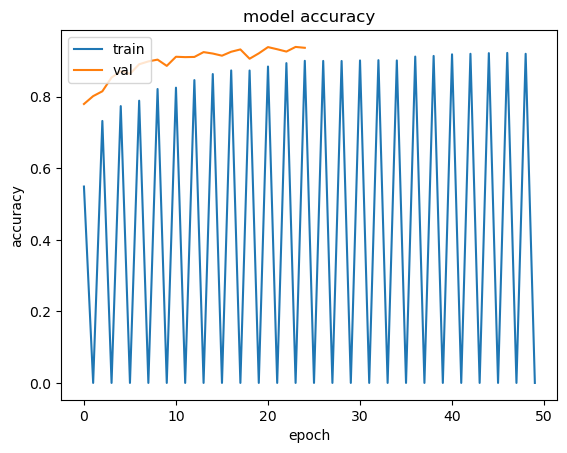

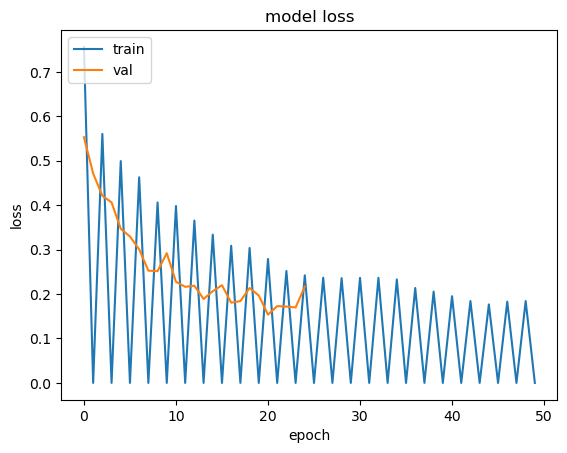

In [7]:
plot_nn_training(results_TL)